# Application - Label Propagation

Label propagation is a technique that used that assigns labels to previously unlabeled datapoints.

Suppose that we had only 50 labeled instances in the MNIST dataset. The goal of this chapter is to show how can we leverage label propagation (particularly with clustering) to improve the performance of the overall classifier.


## Technique 1 - Using Representative Samples

In this technique of label propagation we will use representative samples from the training set propagate out and label similiar instances to those representative samples.

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

# baseline performance with logistic regression
n_labeled = 50
log_reg = LogisticRegression(multi_class='auto', solver='newton-cg')
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.82

Now we'll use kmeans to identify images that are the representative of the sample space. Then we'll show how using these representative images actually improves the performance of the classifier.

In [13]:
import numpy as np
from sklearn.cluster import KMeans


k = 50
kmeans = KMeans(n_clusters=k)

# transform each instance -> [distance to each 50 centroids]
# new shape = (X_train.shape[0], k)
X_digits_dist = kmeans.fit_transform(X_train)

# our goal: find the instance in X train that are the most representative of the training sample space
# to do this, we iterate through each centroid, and find the closest distance instance to that centroid
# axis=0 iterates per column and arg min will return the index of the row that is closest to that axis
# this way, we obtain the index of the images that are closest to the centroid
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

In the real world point, we would manually label the instances. But I wont do that because I have the answers.

In [14]:
y_representative_digits = y_train[representative_digit_idx]
reg = LogisticRegression()
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.94

From 82% to 94%, using the same number of labeled instances. The reason why this work well is because the samples are representive of the population at large. Any other comparisons are therefore more likely to relate. Note that we are identifying 50 "types" of representative groups from the population. Lets how the performs improves as we add more groups.

In [18]:
import progressbar


k_range = range(2, 100)
lg_scores = []
for k in progressbar.progressbar(k_range):
    kmeans = KMeans(n_clusters=k)
    X_digits_dist = kmeans.fit_transform(X_train)
    representative_digit_idx = np.argmin(X_digits_dist, axis=0)
    X_representative_digits = X_train[representative_digit_idx]
    y_representative_digits = y_train[representative_digit_idx]
    reg = LogisticRegression()
    log_reg.fit(X_representative_digits, y_representative_digits)
    lg_scores.append(log_reg.score(X_test, y_test))


100% (98 of 98) |########################| Elapsed Time: 0:00:35 Time:  0:00:35


Text(0.5, 1.0, 'Logistic Regression Score Change by Number of Representive Groups')

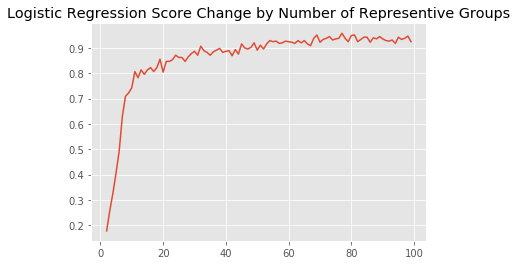

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')


sns.lineplot(x=k_range, y=lg_scores)
plt.title('Logistic Regression Score Change by Number of Representive Groups')

**Main Take away** I when labeling, it is more effective to label the most representative samples as opposed to just random images.

Now we'll lets use the labels we've identified for those 50 clusters to propagate and label instances that are a part of those respective clusters.

In [31]:
# note: np.empty is like np.zeros but faster
#       it assumes that the user fills in all the entries
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    boolean_vec_inst_of_cluster_k_i = kmeans.labels_ == i
    # label all instances belonging to cluster k_i to the most representative label of that cluster
    y_train_propagated[boolean_vec_inst_of_cluster_k_i] = y_representative_digits[i]

# see the new performance
log_reg = LogisticRegression(multi_class='auto', solver='newton-cg')
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9355555555555556

Sometimes you get a marginal boost and sometimes you dont. The issue is that KMeans will mislabel areas around the decision boundary. Here's a thought: what if we didn't propagate all the labels? Instead, what if we propaged only the 20% of the samples closest to the representative sample?

Generalizing this, lets maximize our classification score as a function of the radius from the centroid.

In [42]:
lg_scores_per_percentiles = []
percentiles = np.arange(10, 90, 1)

for p in progressbar.progressbar(percentiles):
    # identify the distance of each instance to the predicted cluster (closest cluster)
    # note: double indexing [] [] will index by r, c into the digits matrix
    X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

    # goal: label all the instances are are too far from their cluster
    # note: we initially trained on 50 clusters
    for i in range(k):
        # boolean vector - identifies training instances in X at are part of cluster i
        in_cluster = (kmeans.labels_ == i)
        # id the distance for each instance in the respected cluster
        cluster_dist = X_cluster_dist[in_cluster]
        # only accept the instances were the distances are closest within some percentile
        cutoff_distance = np.percentile(cluster_dist, p)
        
        # goal: identify the instances that we want to not propagate the labels too
        # both contraints where the distance above the cut off (too far) AND are that
        # it is within the cluster are nessessary because:
        #       X_cluster_dist > cutoff_distance is likly to index into clusters that
        #       are not in the cluster we're interested in label propagation. This is because
        #       the distances minimized already with their closest cluster in `X_cluster_dist`
        # note: X_cluster_dist is normalized (val between 0-1) just like cutoff_distance
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1

    # now only train with the instances that are close to their cluster
    partially_propagated = (X_cluster_dist != -1)
    X_train_partially_propagated = X_train[partially_propagated]
    # we are careful not to use true label data, for demonstration purposes
    # y_train_propagated has already been all labeled, these labels are based off
    # the same classifier, here all the labels come from their closest cluster
    y_train_partially_propagated = y_train_propagated[partially_propagated]
    
    # train the model using these semi-supervised labels
    log_reg = LogisticRegression(multi_class='auto', solver='newton-cg')
    log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
    lg_scores_per_percentiles.append(log_reg.score(X_test, y_test))

100% (80 of 80) |########################| Elapsed Time: 0:00:27 Time:  0:00:27


Text(0.5, 1.0, 'Logistic Regression Score Change by Label Propagation Based of Radial Distance')

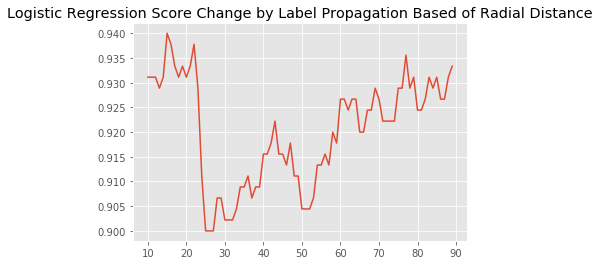

In [45]:
sns.lineplot(x=percentiles, y=lg_scores_per_percentiles)
plt.title('Logistic Regression Score Change by Label Propagation Based of Radial Distance')

In [47]:
idx_max_score = np.argmax(lg_scores_per_percentiles)
print(f'The top lg score was {lg_scores_per_percentiles[idx_max_score]}, found at {percentiles[idx_max_score]} distance percentile from the center.')

The top lg score was 0.94, found at 15 distance percentile from the center.


The reason why this technique works is because instances that are generally closer to the average tend to accurate more of the time.